# HW2P2 Bootcamp
___

* Custom Dataset & DataLoader
* Torchvision ImageFolder Dataset
* Residual Block
* CNN model with Residual Block
* Training 
* Cosine Similarity
* Center Loss
* Triplet Loss
* Large Margin Cosine Loss
* Addictive Angular Margin Loss

In [42]:
!unzip /content/val_data.zip
!unzip /content/test_data.zip

Archive:  /content/val_data.zip
replace 0/6947.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/test_data.zip
replace 0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
!unzip mnist.zip

流式输出内容被截断，只能显示最后 5000 行内容。
 extracting: mnist/training/0/10861.png  
 extracting: mnist/training/0/11116.png  
 extracting: mnist/training/0/11172.png  
 extracting: mnist/training/0/1128.png  
 extracting: mnist/training/0/11281.png  
 extracting: mnist/training/0/11295.png  
 extracting: mnist/training/0/11532.png  
 extracting: mnist/training/0/11742.png  
 extracting: mnist/training/0/11791.png  
 extracting: mnist/training/0/11807.png  
 extracting: mnist/training/0/11887.png  
 extracting: mnist/training/0/11902.png  
 extracting: mnist/training/0/1195.png  
 extracting: mnist/training/0/12168.png  
 extracting: mnist/training/0/12264.png  
 extracting: mnist/training/0/12553.png  
 extracting: mnist/training/0/12568.png  
 extracting: mnist/training/0/12573.png  
 extracting: mnist/training/0/12703.png  
 extracting: mnist/training/0/12723.png  
 extracting: mnist/training/0/12785.png  
 extracting: mnist/training/0/13459.png  
 extracting: mnist/training/0/13528.png  
 extracti

## Imports

In [47]:
import os
import numpy as np
from PIL import Image

import torch
import torchvision   
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

## Custom DataSet with DataLoader
___
We have used a subset of MNIST

In [48]:
class ImageDataset(Dataset):
    def __init__(self, file_list, target_list):
        self.file_list = file_list
        self.target_list = target_list
        self.n_class = len(list(set(target_list)))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img = Image.open(self.file_list[index])
        img = torchvision.transforms.ToTensor()(img)
        label = self.target_list[index]
        return img, label

#### Parse the given directory to accumulate all the images

In [49]:
def parse_data(datadir):
    img_list = []
    ID_list = []
    for root, directories, filenames in os.walk(datadir):  #root: median/1
        for filename in filenames:
            if filename.endswith('.png'):
                filei = os.path.join(root, filename)
                img_list.append(filei)
                ID_list.append(root.split('/')[-1])

    # construct a dictionary, where key and value correspond to ID and target
    uniqueID_list = list(set(ID_list))
    class_n = len(uniqueID_list)
    target_dict = dict(zip(uniqueID_list, range(class_n)))
    label_list = [target_dict[ID_key] for ID_key in ID_list]

    print('{}\t\t{}\n{}\t\t{}'.format('#Images', '#Labels', len(img_list), len(set(label_list))))
    return img_list, label_list, class_n

In [50]:
img_list, label_list, class_n = parse_data('mnist/training')

#Images		#Labels
5000		10


In [51]:
print(img_list[1888])

mnist/training/1/17662.png


In [52]:
trainset = ImageDataset(img_list, label_list)

In [53]:
train_data_item, train_data_label = trainset.__getitem__(0)

In [54]:
print('data item shape: {}\t data item label: {}'.format(train_data_item.shape, train_data_label))

data item shape: torch.Size([1, 28, 28])	 data item label: 8


In [55]:
dataloader = DataLoader(trainset, batch_size=10, shuffle=True, num_workers=1, drop_last=False)

## Torchvision DataSet and DataLoader

In [56]:
imageFolder_dataset = torchvision.datasets.ImageFolder(root='mnist/training/', 
                                                       transform=torchvision.transforms.ToTensor())

In [57]:
imageFolder_dataloader = DataLoader(imageFolder_dataset, batch_size=10, shuffle=True, num_workers=1)

In [58]:
print(imageFolder_dataset.__len__(), len(imageFolder_dataset.classes))

5000 10


## Residual Block

Resnet: https://arxiv.org/pdf/1512.03385.pdf

Here is a basic usage of shortcut in Resnet

In [60]:
# This is the simplest possible residual block, with only one CNN layer.
# Looking at the paper, you can extend this block to have more layers, bottleneck, grouped convs (from shufflenet), etc.
# Or even look at more recent papers like resnext, regnet, resnest, senet, etc.
class SimpleResidualBlock(nn.Module):
    def __init__(self, channel_size, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(channel_size, channel_size, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channel_size)
        if stride == 1:
            self.shortcut = nn.Identity()
        else:
            self.shortcut = nn.Conv2d(channel_size, channel_size, kernel_size=1, stride=stride)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        
        shortcut = self.shortcut(x)
        
        out = self.relu(out + shortcut)
        
        return out

In [61]:
# This has hard-coded hidden feature sizes.
# You can extend this to take in a list of hidden sizes as argument if you want.
class ClassificationNetwork(nn.Module):
    def __init__(self, in_features, num_classes,feat_dim = 2):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_features, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            SimpleResidualBlock(64),
            SimpleResidualBlock(64),
            SimpleResidualBlock(64),
            SimpleResidualBlock(64),
            nn.AdaptiveAvgPool2d((1, 1)), # For each channel, collapses (averages) the entire feature map (height & width) to 1x1
            nn.Flatten(), # the above ends up with batch_size x 64 x 1 x 1, flatten to batch_size x 64
        )
        self.linear = nn.Linear(64, feat_dim)
        self.relu = nn.ReLU(inplace=True)
        self.linear_output = nn.Linear(64,num_classes)        
    def forward(self, x, return_embedding=False):
        embedding = self.layers(x) 
        embedding_out = self.relu(self.linear(embedding))
        output = self.linear_output(embedding)
        if return_embedding:
            return embedding_out,output
        else:
            return output      

In [62]:
train_dataset = torchvision.datasets.ImageFolder(root='mnist/training/', 
                                                 transform=torchvision.transforms.ToTensor())
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, 
                                               shuffle=True, num_workers=8)

dev_dataset = torchvision.datasets.ImageFolder(root='mnist/testing/', 
                                               transform=torchvision.transforms.ToTensor())
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=128, 
                                             shuffle=False, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [63]:
numEpochs = 10
in_features = 3 # RGB channels

learningRate = 5e-2
weightDecay = 5e-5

num_classes = len(train_dataset.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

network = ClassificationNetwork(in_features, num_classes)
network = network.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=learningRate, weight_decay=weightDecay, momentum=0.9)

In [64]:
# Train!
for epoch in range(numEpochs):
    
    # Train
    network.train()
    avg_loss = 0.0
    for batch_num, (x, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        x, y = x.to(device), y.to(device)

        outputs = network(x)

        loss = criterion(outputs, y.long())
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()

        if batch_num % 10 == 9:
            print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch, batch_num+1, avg_loss/50))
            avg_loss = 0.0
    
    # Validate
    network.eval()
    num_correct = 0
    for batch_num, (x, y) in enumerate(dev_dataloader):
        x, y = x.to(device), y.to(device)
        outputs = network(x)
        num_correct += (torch.argmax(outputs, axis=1) == y).sum().item()
        
    print('Epoch: {}, Validation Accuracy: {:.2f}'.format(epoch, num_correct / len(dev_dataset)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0	Batch: 10	Avg-Loss: 0.4395
Epoch: 0	Batch: 20	Avg-Loss: 0.3649
Epoch: 0	Batch: 30	Avg-Loss: 0.3124
Epoch: 0	Batch: 40	Avg-Loss: 0.2905
Epoch: 0, Validation Accuracy: 0.31
Epoch: 1	Batch: 10	Avg-Loss: 0.2585
Epoch: 1	Batch: 20	Avg-Loss: 0.2330
Epoch: 1	Batch: 30	Avg-Loss: 0.2049
Epoch: 1	Batch: 40	Avg-Loss: 0.1720
Epoch: 1, Validation Accuracy: 0.20
Epoch: 2	Batch: 10	Avg-Loss: 0.1653
Epoch: 2	Batch: 20	Avg-Loss: 0.1383
Epoch: 2	Batch: 30	Avg-Loss: 0.1364
Epoch: 2	Batch: 40	Avg-Loss: 0.1131
Epoch: 2, Validation Accuracy: 0.59
Epoch: 3	Batch: 10	Avg-Loss: 0.1518
Epoch: 3	Batch: 20	Avg-Loss: 0.1331
Epoch: 3	Batch: 30	Avg-Loss: 0.1004
Epoch: 3	Batch: 40	Avg-Loss: 0.0920
Epoch: 3, Validation Accuracy: 0.61
Epoch: 4	Batch: 10	Avg-Loss: 0.1056
Epoch: 4	Batch: 20	Avg-Loss: 0.0805
Epoch: 4	Batch: 30	Avg-Loss: 0.0687
Epoch: 4	Batch: 40	Avg-Loss: 0.0674
Epoch: 4, Validation Accuracy: 0.42
Epoch: 5	Batch: 10	Avg-Loss: 0.0889
Epoch: 5	Batch: 20	Avg-Loss: 0.0606
Epoch: 5	Batch: 30	Avg-Loss:

## Computing Cosine Similarity between Feature Embeddings

In [69]:
# Let's try cosine similarity

compute_sim = nn.CosineSimilarity(dim=0)

img_a = dev_dataset[0][0].cpu() # this is class 0
img_b = dev_dataset[1][0].cpu() # this is also class 0
img_c = dev_dataset[51][0].cpu() # this is class 1
img_d = dev_dataset[451][0].cpu() # this is class 9

In [70]:
network.eval()
network = network.cpu()
feats_a = network(img_a.unsqueeze(0), return_embedding=True)[0].squeeze(0)
feats_b = network(img_b.unsqueeze(0), return_embedding=True)[0].squeeze(0)
feats_c = network(img_c.unsqueeze(0), return_embedding=True)[0].squeeze(0)
feats_d = network(img_d.unsqueeze(0), return_embedding=True)[0].squeeze(0)

In [71]:
print("CS b/n two images of class 0: {:.4f}".format(compute_sim(feats_a, feats_b)))
print("CS b/n an image of class 0 and image of class 1: {:.4f}".format(compute_sim(feats_a, feats_c)))
print("CS b/n an image of class 0 and image of class 9: {:.4f}".format(compute_sim(feats_a, feats_d)))

CS b/n two images of class 0: 0.0000
CS b/n an image of class 0 and image of class 1: 0.0000
CS b/n an image of class 0 and image of class 9: 0.0000


## Analysis
We see that CS between images of same class are highest
CS between 0 and 1 is lower, while CS between 0 and 9 are closer (probably because they both have circles)

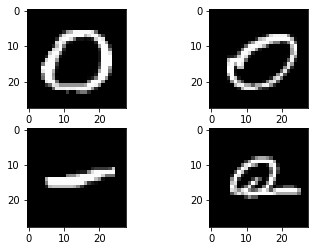

In [72]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(img_a.transpose(2,0))
axarr[0,1].imshow(img_b.transpose(2,0))
axarr[1,0].imshow(img_c.transpose(2,0))
axarr[1,1].imshow(img_d.transpose(2,0))

## Using Center Loss 

The following piece of code for Center Loss has been pulled and modified based on the code from the GitHub Repo: https://github.com/KaiyangZhou/pytorch-center-loss

Reference: Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.

In [73]:
class CenterLoss(nn.Module):
    """
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes, feat_dim, device=torch.device('cpu')):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.device = device
        
        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).to(self.device))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long().to(self.device)
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = []
        for i in range(batch_size):
            value = distmat[i][mask[i]]
            value = value.clamp(min=1e-12, max=1e+12) # for numerical stability
            dist.append(value)
        dist = torch.cat(dist)
        loss = dist.mean()

        return loss

In [77]:
def train_closs(model, data_loader, test_loader, task='Classification'):
    model.train()

    for epoch in range(numEpochs):
        avg_loss = 0.0
        for batch_num, (feats, labels) in enumerate(data_loader):
            feats, labels = feats.to(device), labels.to(device)
            
            optimizer_label.zero_grad()
            optimizer_closs.zero_grad()
            feature, outputs = model(feats,return_embedding=True)


            l_loss = criterion_label(outputs, labels.long())
            c_loss = criterion_closs(feature, labels.long())
            loss = l_loss + closs_weight * c_loss
            
            loss.backward()
            
            optimizer_label.step()
            # by doing so, weight_cent would not impact on the learning of centers
            for param in criterion_closs.parameters():
                param.grad.data *= (1. / closs_weight)
            optimizer_closs.step()
            
            avg_loss += loss.item()

            if batch_num % 50 == 49:
                print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/50))
                avg_loss = 0.0    
            
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
        
        if task == 'Classification':
            val_loss, val_acc = test_classify_closs(model, test_loader)
            train_loss, train_acc = test_classify_closs(model, data_loader)
            print('Train Loss: {:.4f}\tTrain Accuracy: {:.4f}\tVal Loss: {:.4f}\tVal Accuracy: {:.4f}'.
                  format(train_loss, train_acc, val_loss, val_acc))
        else:
            test_verify(model, test_loader)


def test_classify_closs(model, test_loader):
    model.eval()
    test_loss = []
    accuracy = 0
    total = 0

    for batch_num, (feats, labels) in enumerate(test_loader):
        feats, labels = feats.to(device), labels.to(device)
        feature, outputs = model(feats,return_embedding=True)
        
        _,pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
        pred_labels = pred_labels.view(-1)
        
        l_loss = criterion_label(outputs, labels.long())
        c_loss = criterion_closs(feature, labels.long())
        loss = l_loss + closs_weight * c_loss
        
        accuracy += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)
        test_loss.extend([loss.item()]*feats.size()[0])
        del feats
        del labels

    model.train()
    return np.mean(test_loss), accuracy/total

In [75]:
closs_weight = 1
lr_cent = 0.5
feat_dim = 2

network = ClassificationNetwork(in_features, num_classes)
network = network.to(device)


criterion_label = nn.CrossEntropyLoss()
criterion_closs = CenterLoss(num_classes, feat_dim, device)
optimizer_label = torch.optim.SGD(network.parameters(), lr=learningRate, weight_decay=weightDecay, momentum=0.9)
optimizer_closs = torch.optim.SGD(criterion_closs.parameters(), lr=lr_cent)

In [76]:
network.train()
network.to(device)
train_closs(network, train_dataloader, dev_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Loss: 2.6569	Train Accuracy: 0.2140	Val Loss: 2.6057	Val Accuracy: 0.2060
Train Loss: 5.5469	Train Accuracy: 0.2342	Val Loss: 5.4928	Val Accuracy: 0.2440
Train Loss: 2.0479	Train Accuracy: 0.4176	Val Loss: 2.0455	Val Accuracy: 0.4040
Train Loss: 0.9210	Train Accuracy: 0.6406	Val Loss: 0.8824	Val Accuracy: 0.6220
Train Loss: 0.3671	Train Accuracy: 0.8792	Val Loss: 0.3021	Val Accuracy: 0.9100
Train Loss: 0.9403	Train Accuracy: 0.6892	Val Loss: 0.9641	Val Accuracy: 0.6640
Train Loss: 0.6652	Train Accuracy: 0.7712	Val Loss: 0.5523	Val Accuracy: 0.8040
Train Loss: 0.6413	Train Accuracy: 0.7824	Val Loss: 0.6028	Val Accuracy: 0.7980
Train Loss: 0.4465	Train Accuracy: 0.8560	Val Loss: 0.4412	Val Accuracy: 0.8580
Train Loss: 0.3890	Train Accuracy: 0.8818	Val Loss: 0.3681	Val Accuracy: 0.8900


## Using Triplet Loss


You can make a dataloader that returns a tuple of three images. Two being from the same class and one from a different class. You can then use triplet loss to seperate out the different class pair distance and decrease same class pair distance.

More on this link: https://github.com/adambielski/siamese-triplet/blob/master/losses.py

In [79]:
import torch
import torch.nn as nn
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)

# Anchor image
face_img1, label_img1 = train_dataset.__getitem__(0) 
# Positive 
face_img2, label_img2 = train_dataset.__getitem__(1)
# Negative
face_img3, label_img3 = train_dataset.__getitem__(-1)

print(label_img1, label_img2, label_img3)
## face_img1 and face_img2 are from the same class and face_img3 is from a different class.

loss = triplet_loss(face_img1, face_img2, face_img3)
print ("Loss={:0.2f}".format(loss))

0 0 9
Loss=1.53


## Using Contrastive Loss (For Siamese Network)

https://medium.com/@maksym.bekuzarov/losses-explained-contrastive-loss-f8f57fe32246

In [80]:
class ContrastiveLoss(torch.nn.Module):

    def _init_(self, margin=2.0):
        super(ContrastiveLoss, self)._init_()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Using Large Margin Cosine Loss

More on these links.
https://github.com/hiteyoshi/CosFace_pytorch
https://github.com/YirongMao/softmax_variants/blob/master/model_utils.py

In [38]:

class LMCL_loss(nn.Module):
    """
        Refer to paper:
        Hao Wang, Yitong Wang, Zheng Zhou, Xing Ji, Dihong Gong, Jingchao Zhou,Zhifeng Li, and Wei Liu
        CosFace: Large Margin Cosine Loss for Deep Face Recognition. CVPR2018
        re-implement by yirong mao
        2018 07/02
        """

    def __init__(self, num_classes, feat_dim, s=7.00, m=0.2):
        super(LMCL_loss, self).__init__()
        self.feat_dim = feat_dim
        self.num_classes = num_classes
        self.s = s
        self.m = m
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))

    def forward(self, feat, label):
        batch_size = feat.shape[0]
        norms = torch.norm(feat, p=2, dim=-1, keepdim=True)
        nfeat = torch.div(feat, norms)

        norms_c = torch.norm(self.centers, p=2, dim=-1, keepdim=True)
        ncenters = torch.div(self.centers, norms_c)
        logits = torch.matmul(nfeat, torch.transpose(ncenters, 0, 1))

        y_onehot = torch.FloatTensor(batch_size, self.num_classes)
        y_onehot.zero_()
        y_onehot = Variable(y_onehot).cuda()
        y_onehot.scatter_(1, torch.unsqueeze(label, dim=-1), self.m)
        margin_logits = self.s * (logits - y_onehot)

        return logits, margin_logits



## Using addictive angular margin loss

More on these links.
https://github.com/cvqluu/Angular-Penalty-Softmax-Losses-Pytorch/blob/master/loss_functions.py